In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

while 'jupyter' in os.getcwd():
    os.chdir("../")

!pwd

/Users/msat/projects/white-box-nn


In [1304]:
import torch
from torch import einsum, nn
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F

import pandas as pd
import seaborn as sn
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt

from collections import OrderedDict

import kornia
from kornia.geometry.transform import affine, translate, rotate
from kornia.enhance import adjust_brightness, adjust_contrast, adjust_hue, adjust_saturation, adjust_gamma

from art.attacks.evasion import FastGradientMethod, AutoAttack, AutoProjectedGradientDescent, SquareAttack, BoundaryAttack
from art.estimators.classification import PyTorchClassifier

from lib.datamodules import MNISTDataModule
from lib.helpers import hh, normalize_weight_, normalize_weight
from lib.lightning_modules.cls_module import ClsModule, compute_confidence

from lib.modules.augment import Noise
from lib.modules.sf_layers import AffineLayer, TwoStepFunction, ConvLayer
from lib.modules.sf_samplers import SFSampler, AffineSampler, RotationSampler

BATCH_SIZE = 200

# LABELS = None
# LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
LABELS = [3, 5]
N_CLASSES = len(LABELS) if LABELS else 10

prefix = "mnist"
IMG_SHAPE = (1, 28, 28)
EPS = 0.3
STEP_SIZE = 0.1

VERSION = 0
MODEL_SAVE_PATH = f"models/{prefix}/wbnn_state_dict_{VERSION}.pt"
DIM_INPUT = torch.prod(torch.tensor(IMG_SHAPE))
LOGS_DIR = f"logs/{prefix}_sf_model/"

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [1143]:
datamodule = MNISTDataModule(batch_size=BATCH_SIZE, labels=LABELS, shape=IMG_SHAPE[1:])

datamodule.prepare_data()
datamodule.setup()

In [1233]:
x_test_all, y_test_all = next(iter(datamodule.test_dataloader(len(datamodule.mnist_test))))
x_test, y_test = x_test_all[:48], y_test_all[:48]
x_test_small, y_test_small = x_test_all[32:48], y_test_all[32:48]

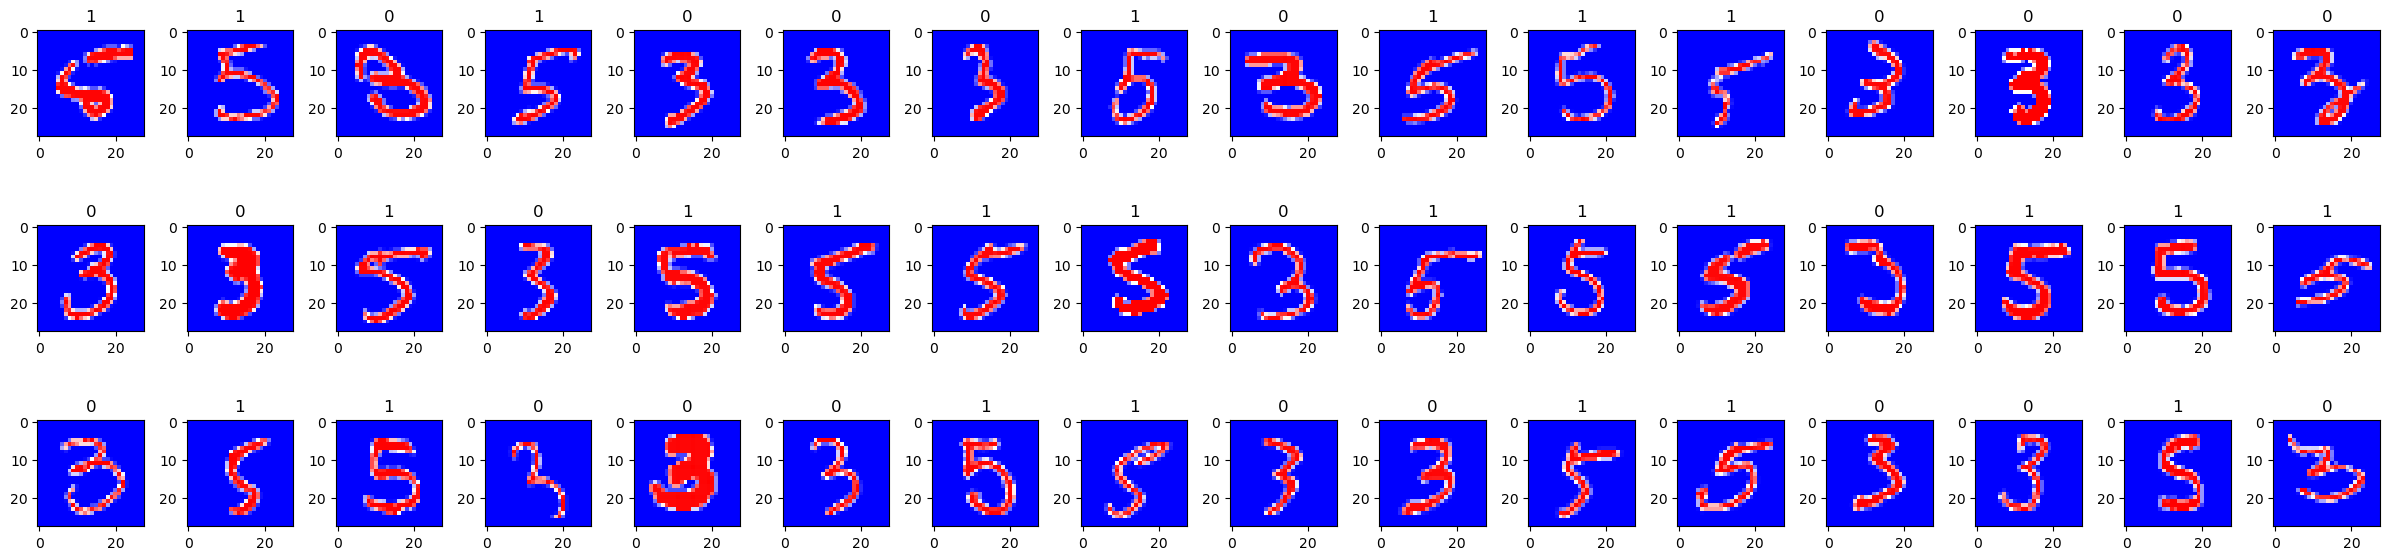

In [1234]:
hh.plot_example(x_test, y_test)

# Train

In [1203]:
seed = 314
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

augment = nn.Sequential(
    Noise(mean=0.05, scale=0.25, clip=True, p=0.7),
)

latent_dim = 2

pixel_layer = TwoStepFunction(10)

conv_layer = ConvLayer(
    sampler=RotationSampler(16),
    n_kernels=2,
    kernel_size=5,
    act=nn.ReLU(),
    # add_bias=True,
)

affine_layer = AffineLayer(
    sampler=AffineSampler(32, dim_pose_group=latent_dim),
    inp_shape=IMG_SHAPE,
    feature_shape=(1, 18, 18),
    out_dim=latent_dim,
    act=nn.ReLU(),
    # add_bias=True,
)

head = nn.Linear(
    latent_dim,
    N_CLASSES,
    bias=False,
    # bias=True,
)
with torch.no_grad():
    w = head.weight
    nn.init.eye_(w)
    w.add_(-0.5)
    w.mul_(2.)

backbone = nn.Sequential(OrderedDict([
    ('pixel', pixel_layer),
    ('conv', conv_layer),
    ('affine', affine_layer),
    ('head', head),
]))

model = ClsModule(
    learning_rate=3e-3, # BEST
    # weight_decay=3e-7,# 0.00001,
    # weight_decay=3e-6,# BEST?
    weight_decay=0.0,
    noise_eps=EPS,
    adv_prob=0.,
    # adv_prob=1.0,
    val_adv_prob=1.0,
    n_classes=N_CLASSES,
    augment=augment,
    backbone=backbone,
)

bb = model.backbone
model(torch.zeros_like(x_test))  # sanity check + potential lazy initialization
pass

In [1204]:
batch_size = BATCH_SIZE
# batch_size = 1
datamodule = MNISTDataModule(batch_size=batch_size, labels=LABELS, shape=IMG_SHAPE[1:])

trainer = Trainer(
    accelerator="auto",
    # precision=16,
    # devices=1 if torch.cuda.is_available() else None,
    devices="auto",
    # max_epochs=2,
    # max_epochs=3,
    # max_epochs=5,
    # max_epochs=10,
    max_epochs=15,  # this
    # max_epochs=20,
    # max_epochs=30,
    callbacks=[TQDMProgressBar(refresh_rate=2)],
    logger=CSVLogger(save_dir=LOGS_DIR, version=VERSION),
)

trainer.fit(
    model=model,
    datamodule=datamodule,
    # ckpt_path=f"{LOGS_DIR}lightning_logs/version_{version}/checkpoints/epoch=9-step=1130.ckpt",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/mnist_sf_model/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name           | Type               | Params
------------------------------------------------------
0 | loss           | CrossEntropyLoss   | 0     
1 | augment        | Sequential         | 0     
2 | backbone       | Sequential         | 1.1 K 
3 | train_accuracy | MulticlassAccuracy | 0     
4 | val_accuracy   | MulticlassAccuracy | 0     
5 | test_accuracy  | MulticlassAccuracy | 0     
6 | corr_avg_conf  | MeanMetric         | 0     
7 | miss_avg_conf  | MeanMetric         | 0     
8 | miss_max_conf  | MaxMetric      

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


# Inspect model

In [1205]:
# Test on full test (PGD attack)
model.to(device)
model.eval()
trainer.test(model, datamodule)
model.eval()
model.training

/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      corr_avg_conf          0.930820643901825
      miss_avg_conf         0.7529891133308411
      miss_max_conf         0.9969183206558228
      test_adv_acc          0.9216614365577698
      test_adv_loss         0.20614998042583466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


False

,train_loss,train_acc,val_adv_loss,val_adv_acc,test_adv_loss,test_adv_acc,corr_avg_conf,miss_avg_conf,miss_max_conf
epoch,,,,,,,,,
11,0.033184,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,0.212836,0.922187,NaN,NaN,NaN,NaN,NaN
12,0.027458,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.035050,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,0.211933,0.923239,NaN,NaN,NaN,NaN,NaN
13,0.040652,0.985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,0.228296,0.912723,NaN,NaN,NaN,NaN,NaN
14,0.024373,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,0.209892,0.922187,NaN,NaN,NaN,NaN,NaN


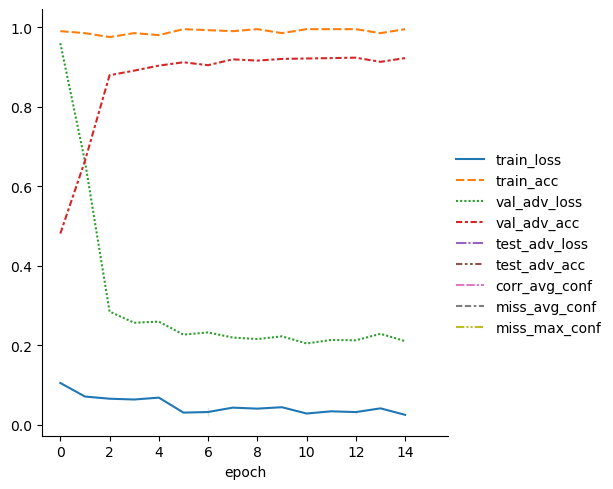

In [1206]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"], del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").tail(10))
met = metrics[metrics.index >= 0] # first few epochs might be an outliers
sn.relplot(data=met, kind="line")

In [1301]:
def visualize_processing_steps(bb, x):
    x0 = bb.pixel(x)
    x1 = bb.conv(x0)
    x2, f = bb.affine(x1, with_features=True)
    x3 = bb.head(x2)

    f1, f2 = torch.split(f, 1, dim=1)
    f1, f2 = f1[:, 0], f2[:, 0]
    f1, f2 = f1 + 0.1 * x1, f2 + 0.1 * x1

    y = [(round(scores[0].item(), ndigits=2), round(scores[1].item(), ndigits=2)) for scores in x3.softmax(dim=1)]
    y += ['pixel' for _ in range(len(x3))]
    y += ['conv' for _ in range(len(x3))]
    y += [round(e.item(), ndigits=2) for e in x2[:, 0]]
    y += [round(e.item(), ndigits=2) for e in x2[:, 1]]

    ret = torch.cat([x, x0, x1, f1, f2], dim=0)

    return ret, y

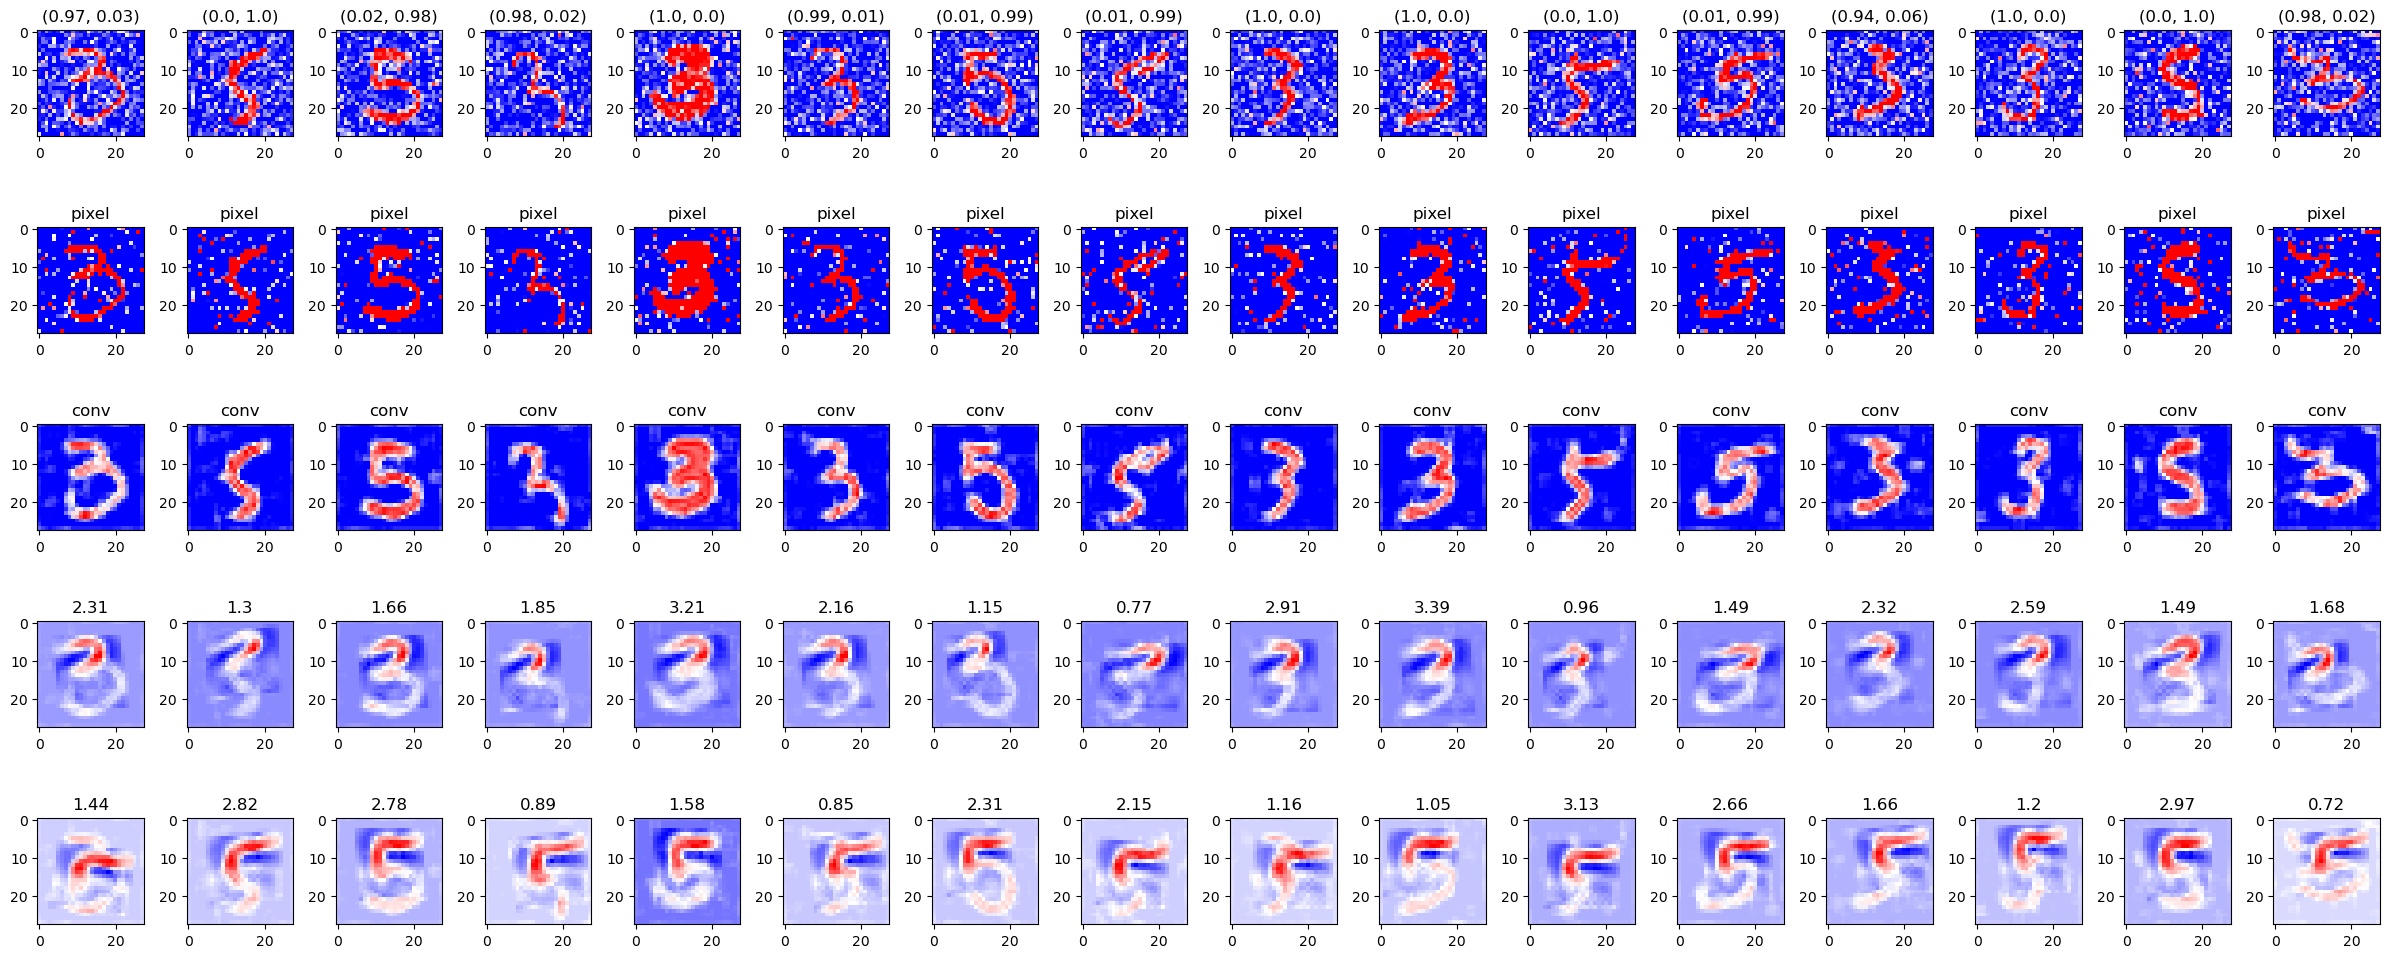

In [1302]:
xx = augment(x_test_small)
layer_vis, labels = visualize_processing_steps(bb, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

Learned 2-step: TwoStepFunction(0.357, 0.558, 0.824, 0.713, scales=[0.002, 0.168, 0.271, 0.001])


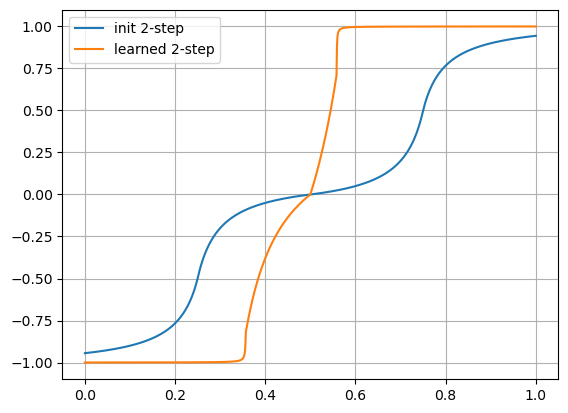

In [1278]:

n_steps = 1000
thr = torch.tensor(range(n_steps + 1)) / n_steps

val_learned = bb.pixel(thr)
val_init = TwoStepFunction(10)(thr)
plt.plot(thr, val_init.detach(), label='init 2-step')
plt.plot(thr, val_learned.detach(), label='learned 2-step')
plt.legend()

print("Learned 2-step:", bb.pixel)

ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

tensor(-0.2315) tensor(0.4214)


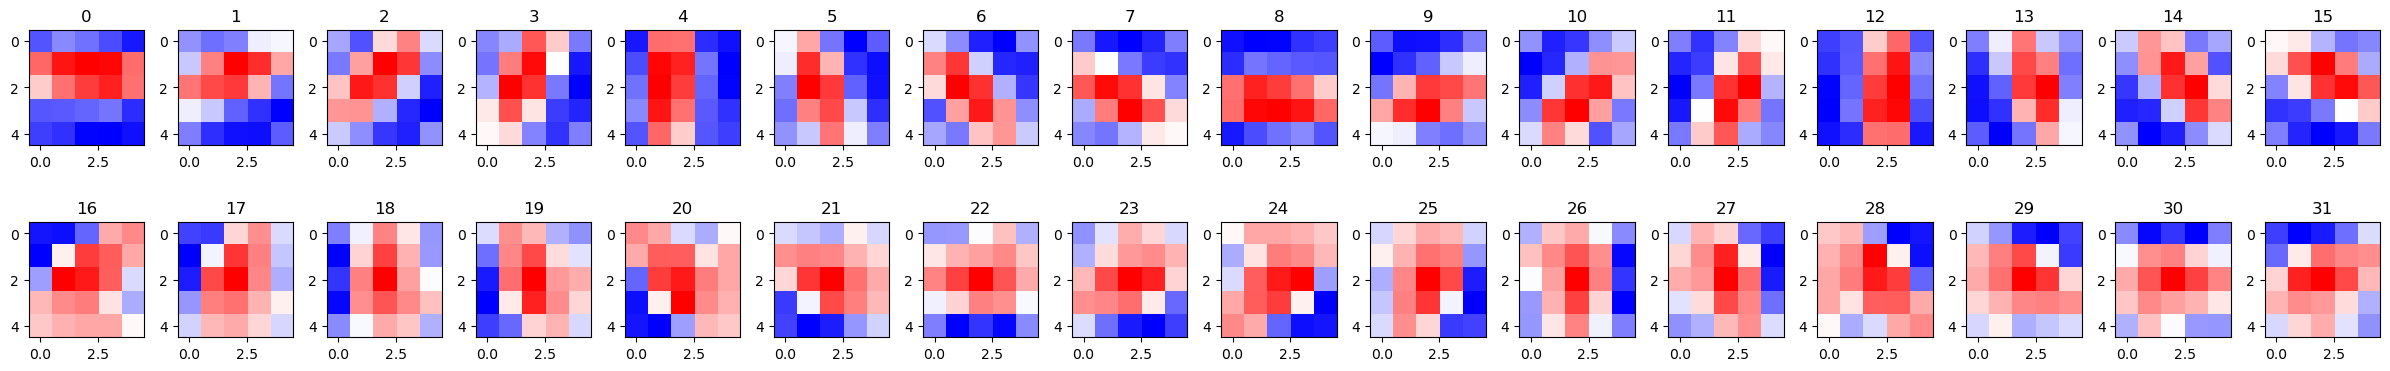

In [1276]:
cc = bb.conv.get_weight().detach().flatten(0, 1)
print(cc.min(), cc.max())

hh.plot_example(cc, n_row=2, n_col=16)

tensor(-0.1561, grad_fn=<MinBackward1>) tensor(0.2506, grad_fn=<MaxBackward1>)


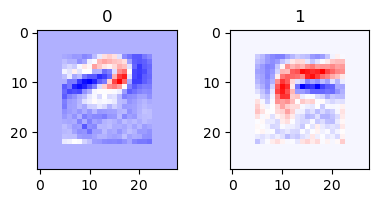

In [1274]:
f = bb.affine.get_features()
print(f.min(), f.max())

hh.plot_example(f, list(range(len(f))), n_col=2, n_row=1)
# hh.plot_example(f, list(range(len(f))), n_col=16, n_row=4)

tensor(-0.1735) tensor(0.2659)


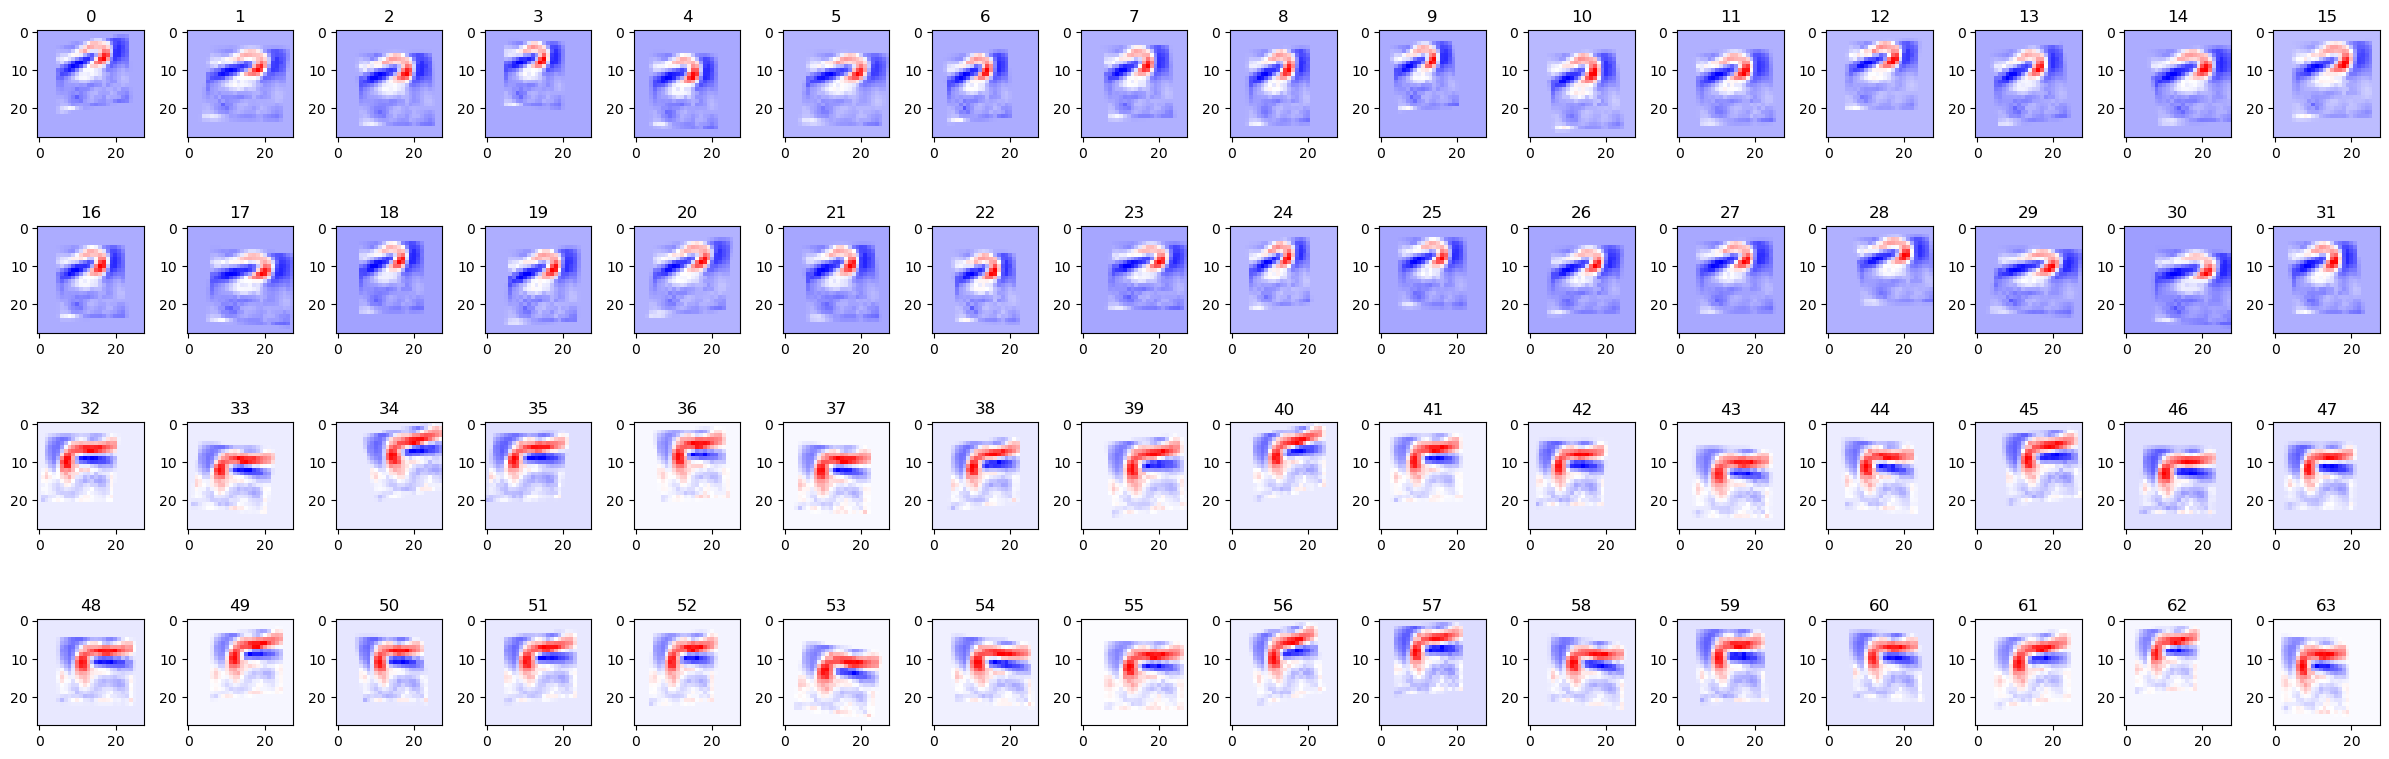

In [1265]:
ff = bb.affine.get_weight()
ff = ff.flatten(0, 1)

print(ff.min(), ff.max())

max_rows = 16
hh.plot_example(ff, list(range(len(ff))), n_col=16, n_row=min(max(ff.shape[0]//16, 2), max_rows))

In [1266]:
bb.head.weight.round(decimals=2)

tensor([[ 1.9400, -1.8700],
        [-1.9400,  1.8700]], grad_fn=<RoundBackward1>)

In [1263]:
poses = torch.cat(list(bb.affine.sampler.poses))
poses.round(decimals=2)
poses[:, :, :2].min(), poses[:, :, :2].max(), poses.min(), poses.max()

(tensor(-0.2221, grad_fn=<MinBackward1>),
 tensor(1.1998, grad_fn=<MaxBackward1>),
 tensor(-2.6338, grad_fn=<MinBackward1>),
 tensor(3.0804, grad_fn=<MaxBackward1>))

# Save/Load

In [1270]:
# if False:
if True:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [1273]:
# if False:
if True:
    model_state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
    model.load_state_dict(model_state_dict)
    bb = model.backbone

# Attack

In [1310]:
def get_classifier(model):
    return PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=model.configure_optimizers(),
        input_shape=IMG_SHAPE,
        nb_classes=N_CLASSES,
    )
    
def perform_attack(classifier, attack, x_test, y_test):
    x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().numpy()))

    predictions = classifier.predict(x_test.cpu())
    correct = np.argmax(predictions, axis=1) == y_test.numpy()
    accuracy = np.sum(correct) / len(y_test)
    print("Accuracy on clean test examples: {}%".format(accuracy * 100))

    predictions_adv = classifier.predict(x_test_adv)
    correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
    accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
    print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

    y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))

    return x_test_adv, y_tests

## Quick attacks on small subset

### FGSM

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 97.91666666666666%


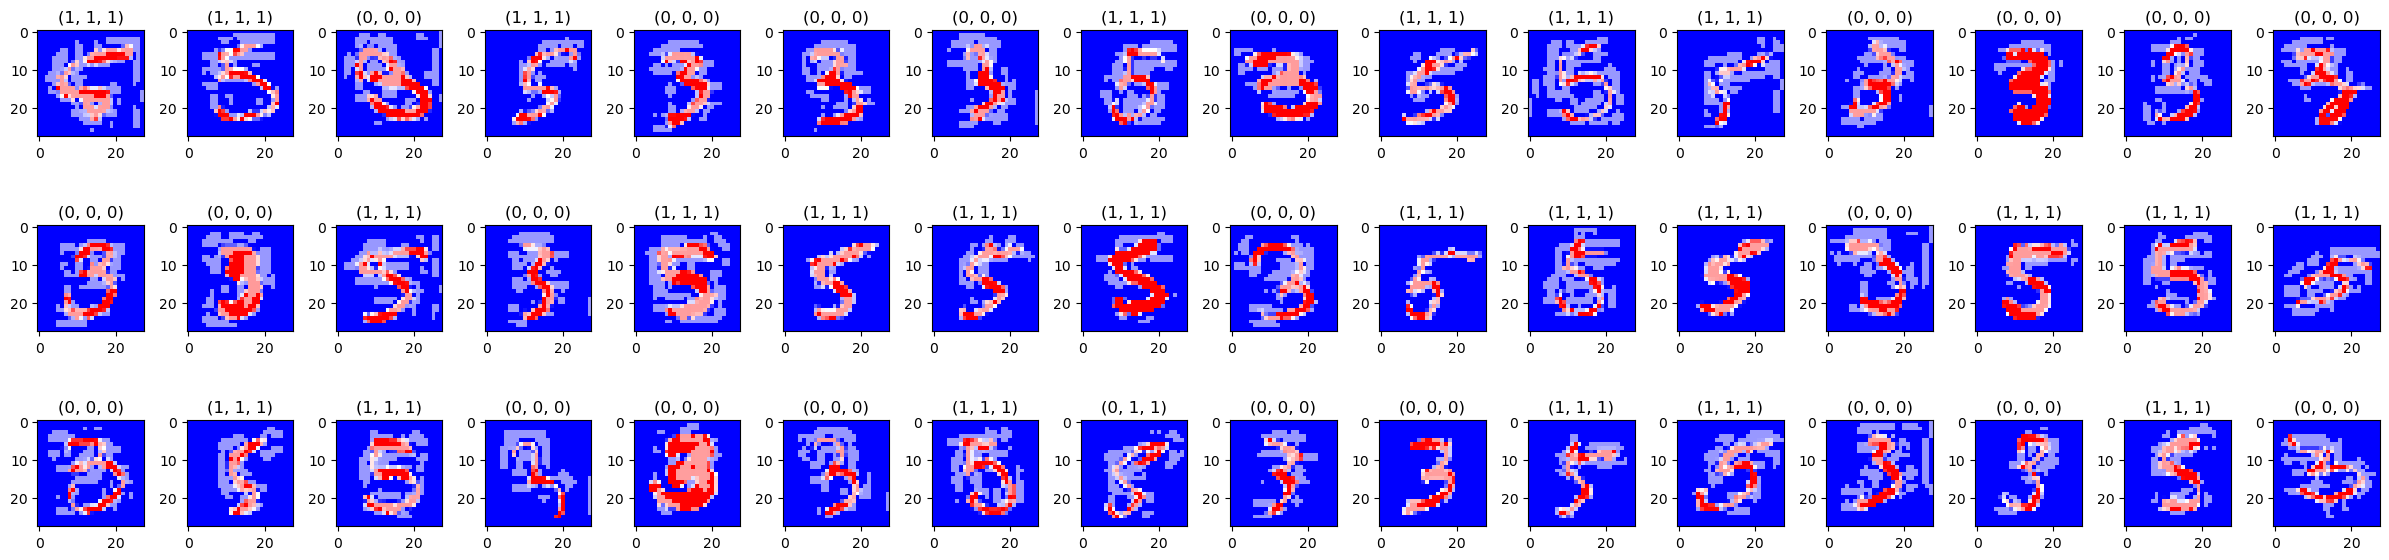

In [1311]:
classifier = get_classifier(model)
attack = FastGradientMethod(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

### AutoPGD

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 95.83333333333334%


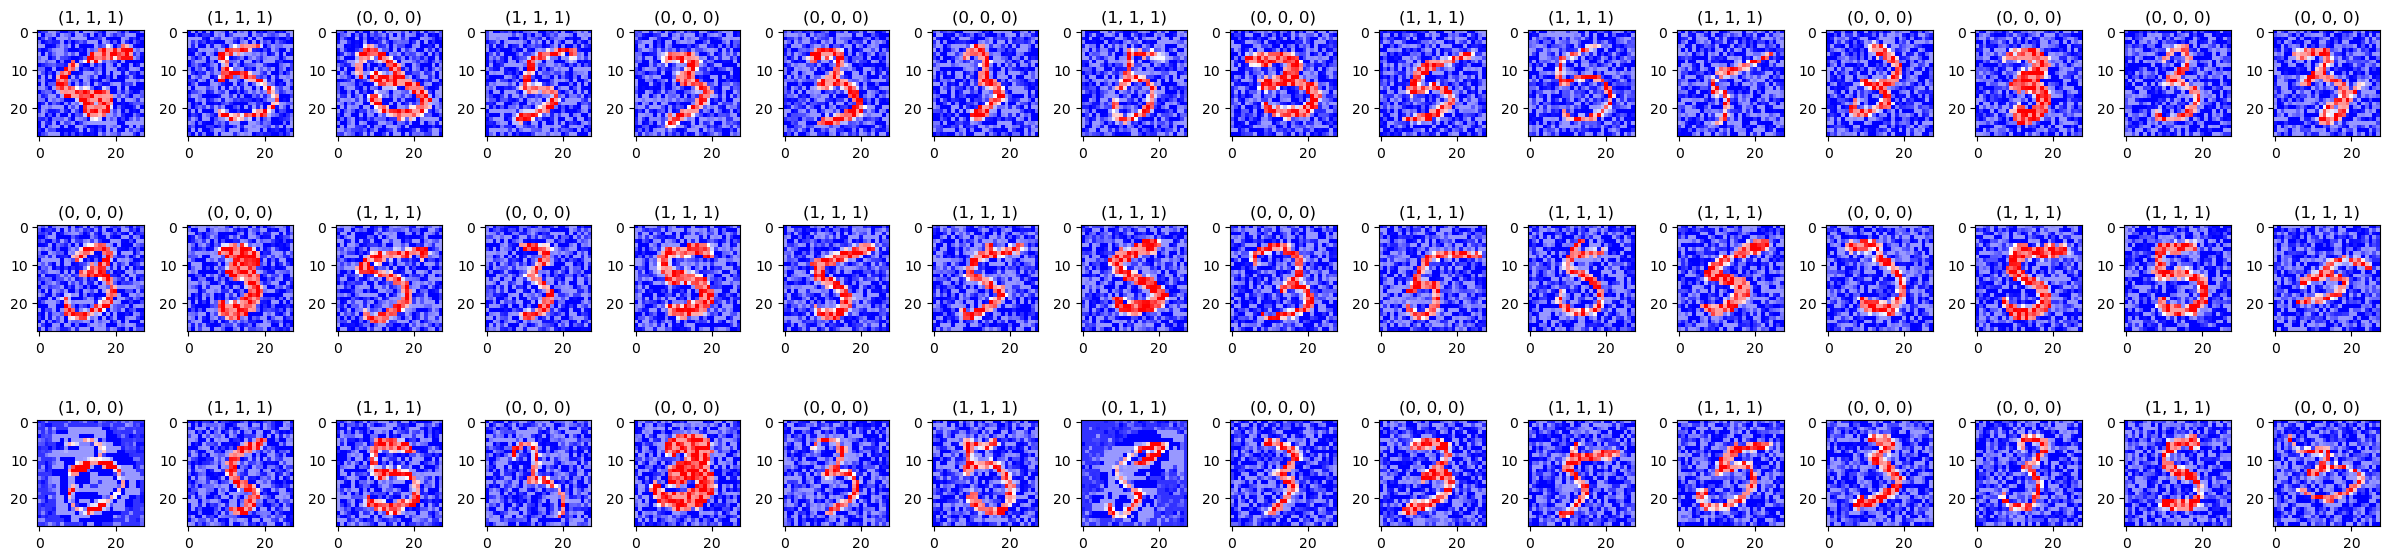

In [1312]:
classifier = get_classifier(model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

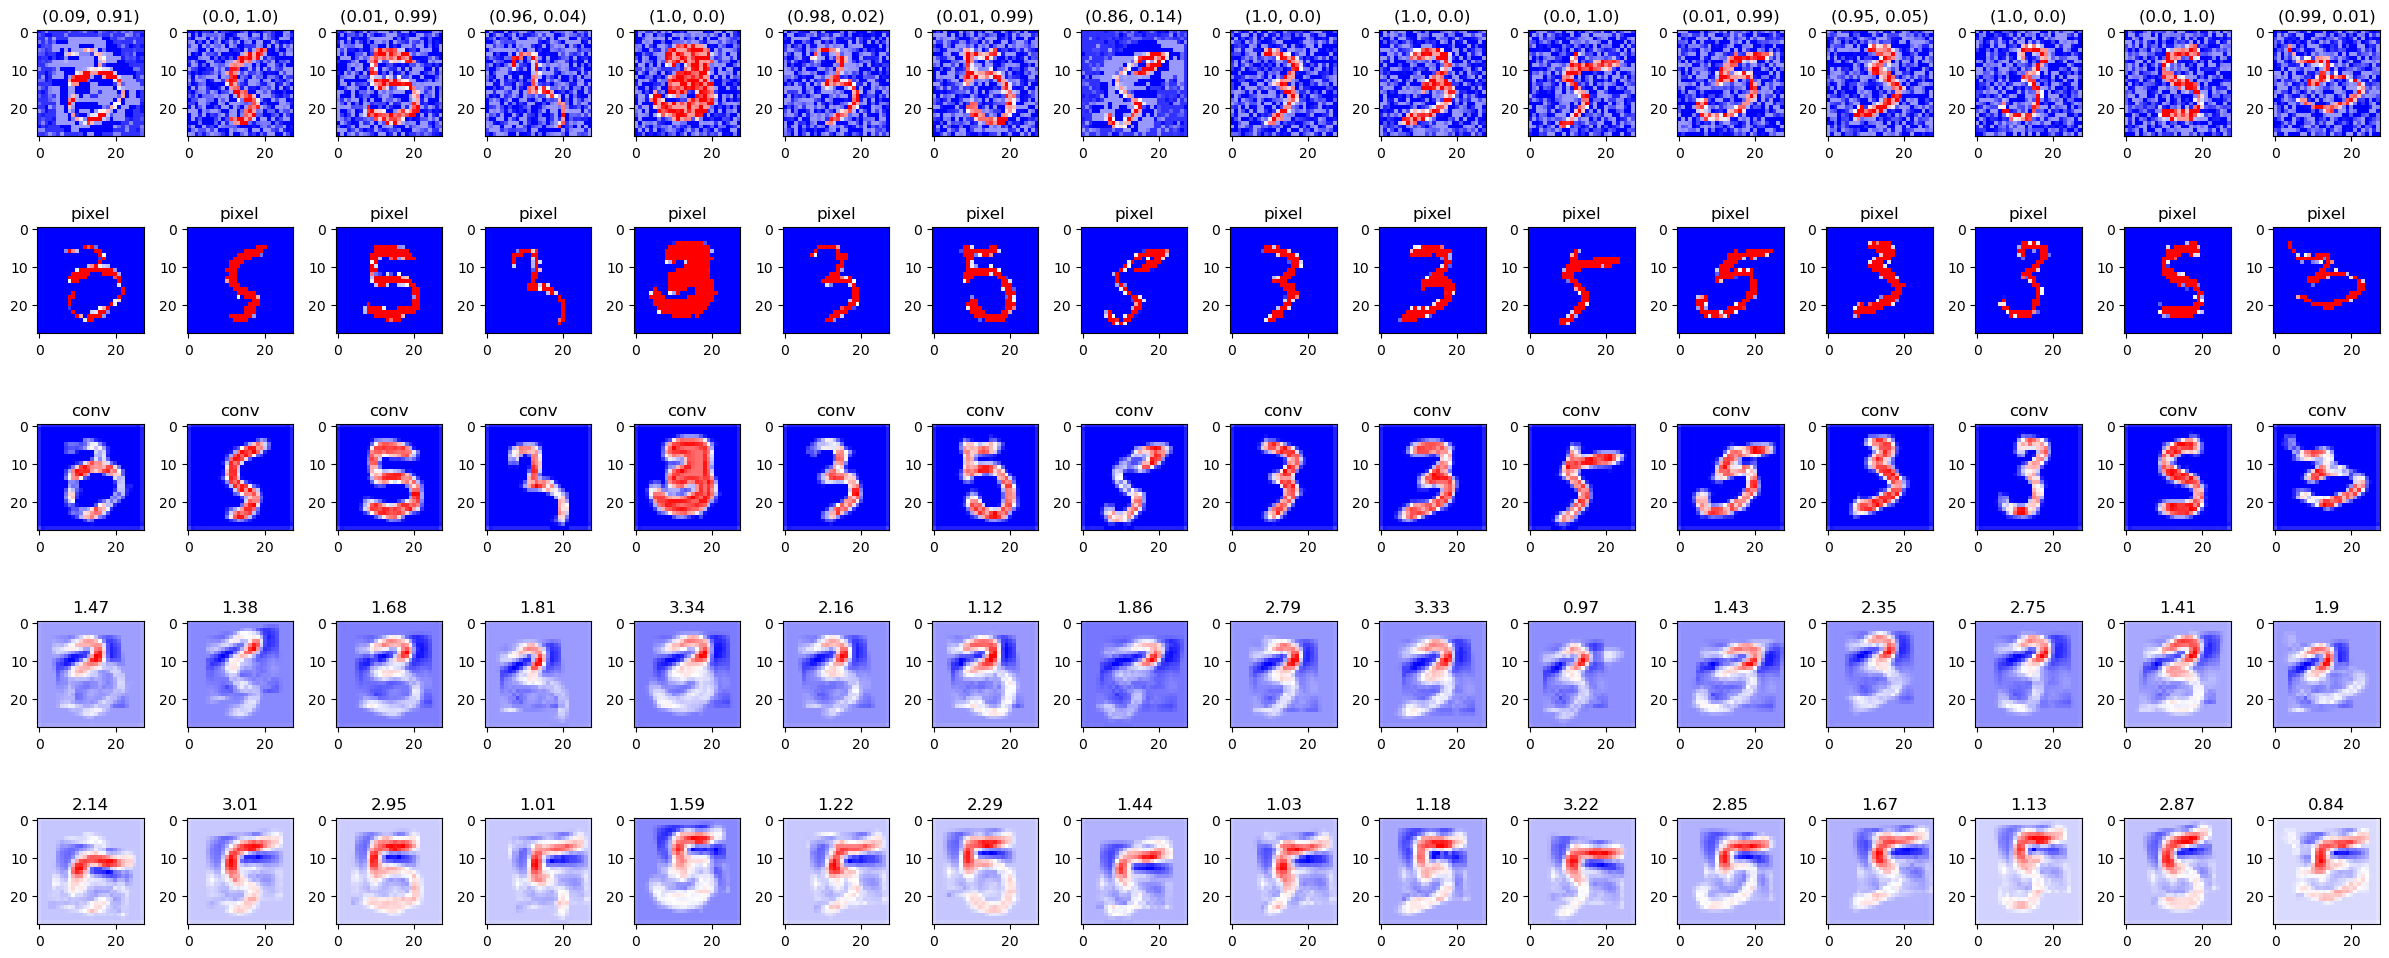

In [1313]:
xx = x_test_adv[32:48]
layer_vis, labels = visualize_processing_steps(bb, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

In [1314]:
corr, miss = compute_confidence(model(x_test_adv), y_test)
corr.mean(), miss.mean()

(tensor(0.9935, grad_fn=<MeanBackward0>),
 tensor(0.8876, grad_fn=<MeanBackward0>))

### AutoPGD DLR loss

In [1322]:
class DLRAdapter(nn.Module):
    # DLR loss requires at least 3 labels so we add a dummy label to the output
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        x = torch.cat([x, -100*torch.ones_like(x)[:, :1]], dim=1)
        return x
    
    def configure_optimizers(self):
        return self.model.configure_optimizers()

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 95.83333333333334%


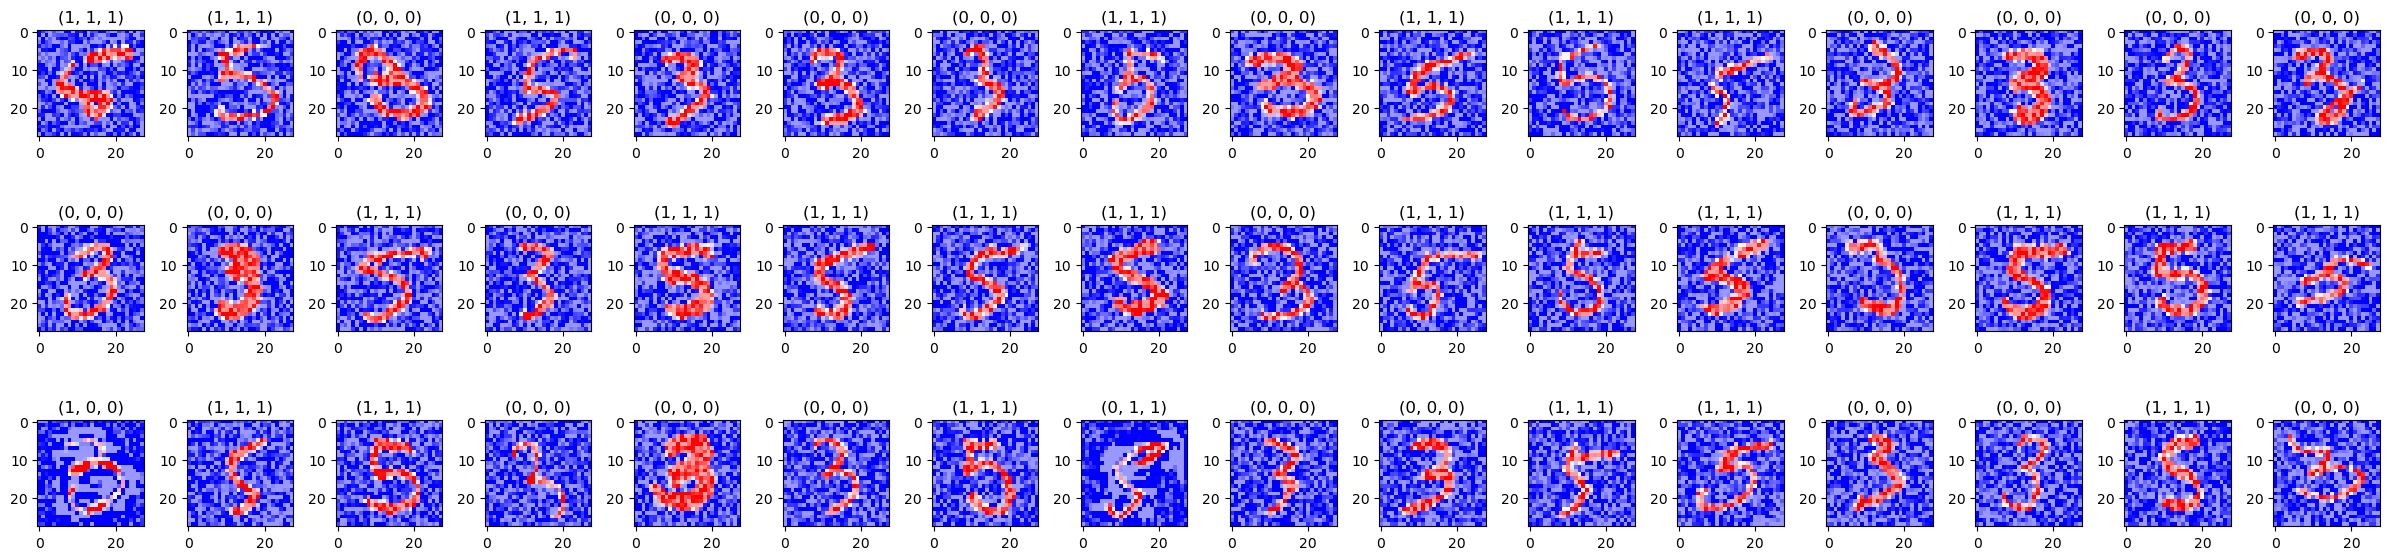

In [1323]:
adapted_model = DLRAdapter(model)

classifier = get_classifier(adapted_model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, loss_type="difference_logits_ratio")
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

## Slow attacks on tiny subset

### Square attack

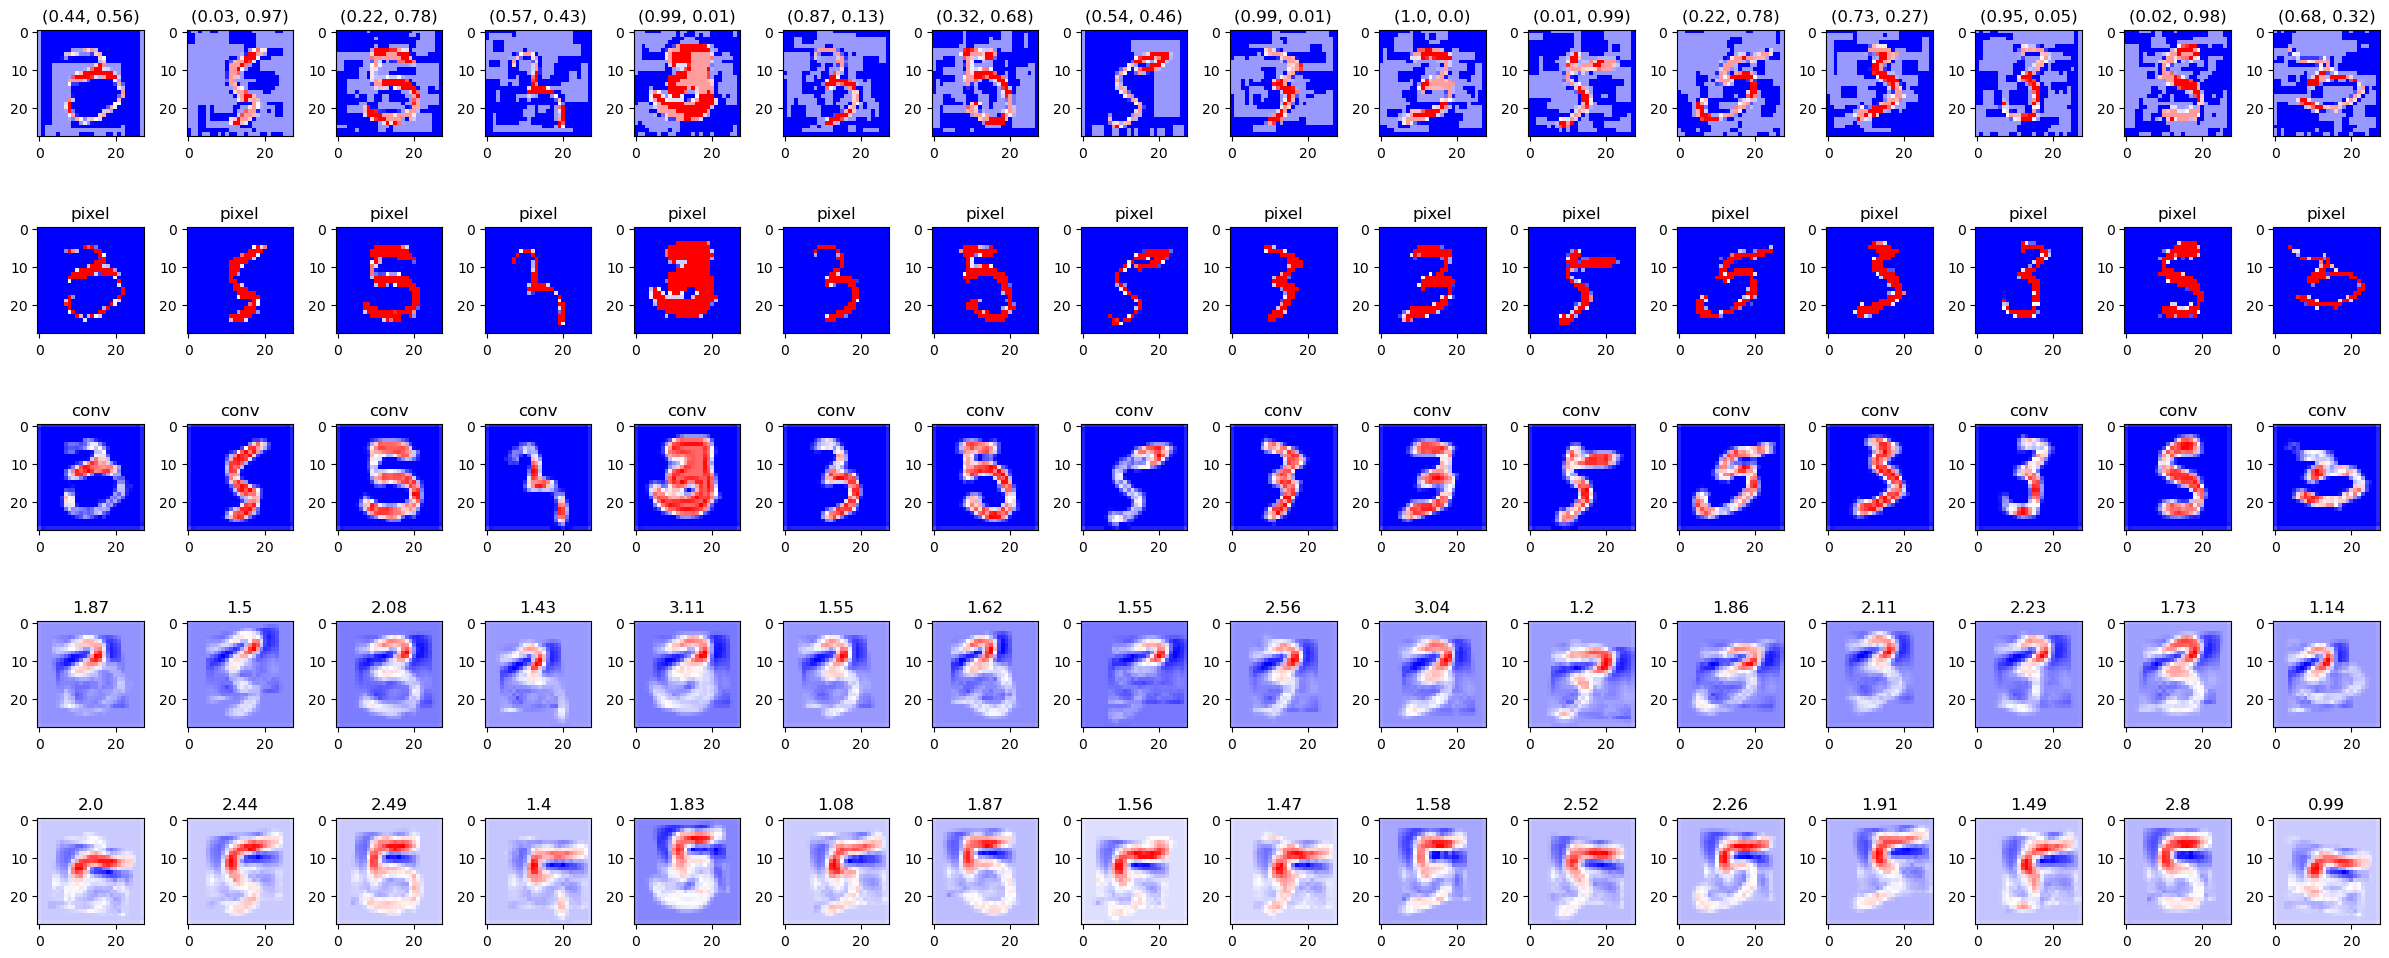

In [1317]:
classifier = get_classifier(model)
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=5000, eps=EPS, p_init=0.8, nb_restarts=5)
x_test_adv_small, y_tests_small = perform_attack(classifier, attack, x_test_small, y_test_small)

xx = x_test_adv_small
layer_vis, labels = visualize_processing_steps(bb, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

In [1319]:
corr, miss = compute_confidence(model(x_test_adv), y_test_small)
corr.mean(), miss.mean()

(tensor(0.8545, grad_fn=<MeanBackward0>),
 tensor(0.5514, grad_fn=<MeanBackward0>))

### Boundary attack

Boundary attack:   0%|          | 0/16 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 0.0%


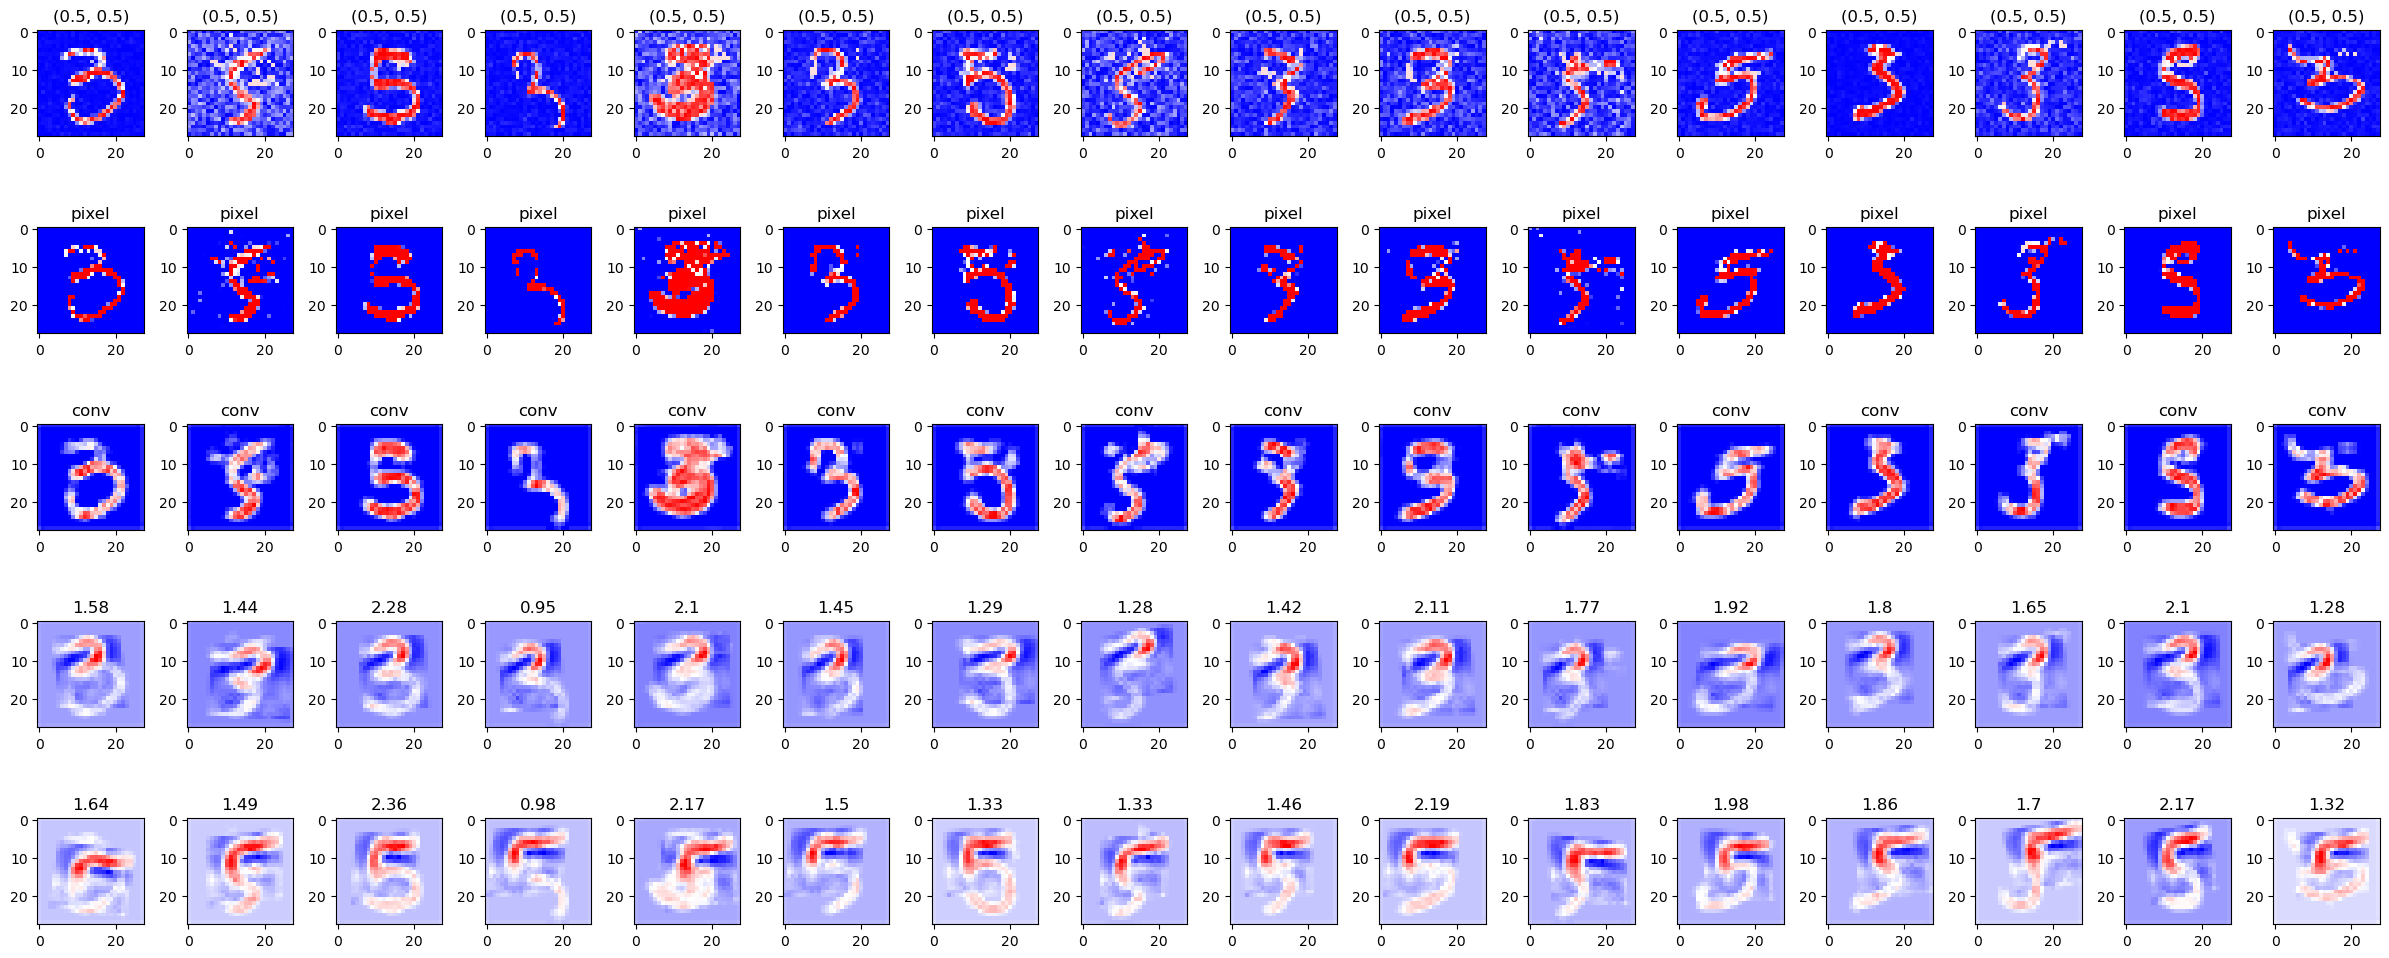

In [1327]:
classifier = get_classifier(model)
attack = BoundaryAttack(estimator=classifier, targeted=False, min_epsilon=0.0, max_iter=1000)
x_test_adv_small, y_tests_small = perform_attack(classifier, attack, x_test_small, y_test_small)

xx = x_test_adv_small
layer_vis, labels = visualize_processing_steps(bb, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

## Attacks on full test

In [1326]:
adapted_model = DLRAdapter(model)

classifier = get_classifier(adapted_model)
attack = AutoAttack(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv_all, y_tests_all = perform_attack(classifier, attack, x_test_all, y_test_all)

hh.plot_example(x_test_adv_all, y_tests_all)

In [ ]:
xx = x_test_adv_all[32:48]
layer_vis, labels = visualize_processing_steps(bb, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

In [ ]:
corr, miss = compute_confidence(model(x_test_adv_all), y_test_all)
corr.mean(), miss.mean()